[안녕] (1.03s ~ 1.28s, 0.25s)  ↔  [hello] (0.00s ~ 0.78s, 0.78s)  → Δ = 0.53s
[하 + 세요] (1.69s ~ 1.83s, 0.14s)  ↔  [my + name + is + jo + yoon + jang] (1.41s ~ 3.05s, 1.64s)  → Δ = 1.50s
[제] (1.91s ~ 1.97s, 0.06s)  ↔  [nice] (4.99s ~ 5.47s, 0.48s)  → Δ = 0.42s
[이름 + 은 + 조윤장 + 입니다] (2.65s ~ 4.50s, 1.85s)  ↔  [to + meet + you] (6.10s ~ 7.07s, 0.97s)  → Δ = 0.88s
[만나 + 서] (5.44s ~ 5.86s, 0.42s)  ↔  [please] (7.71s ~ 8.40s, 0.69s)  → Δ = 0.27s
[반갑 + 습니다] (6.20s ~ 6.99s, 0.79s)  ↔  [take + care + of + me] (9.52s ~ 10.68s, 1.16s)  → Δ = 0.37s


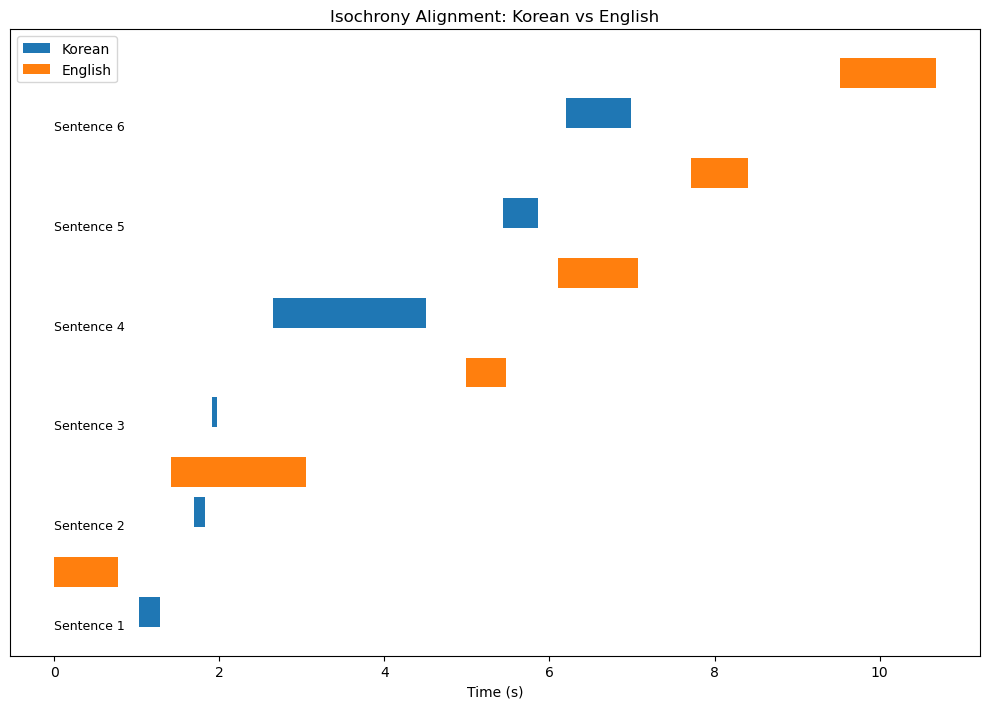


✅ Final Isochrony Score: 0.942


In [2]:
import matplotlib.pyplot as plt
from textgrid import TextGrid
import numpy as np

def normalize(text):
    return text.replace(" ", "").replace(".", "").replace(",", "").lower()

def find_combined_interval_multiple(tier, word_list):
    normalized_words = [normalize(w) for w in word_list if w.strip()]
    for i in range(len(tier)):
        mark = normalize(tier[i].mark)
        if not mark:
            continue

        matched = True
        j, k = 0, i
        start_time = None

        while j < len(normalized_words) and k < len(tier):
            mark_k = normalize(tier[k].mark)
            if not mark_k:
                k += 1
                continue
            if normalized_words[j] != mark_k:
                matched = False
                break
            if start_time is None:
                start_time = tier[k].minTime
            j += 1
            k += 1

        if matched:
            return (start_time, tier[k - 1].maxTime)
    return None

# 경로 설정
ko_tg = TextGrid.fromFile("./sound_sample/korean_yunjang/윤장목소리1.TextGrid")
en_tg = TextGrid.fromFile("./sound_sample/AI_eng_yunjang/mine_en.TextGrid")
tier_ko = ko_tg.getFirst("words")
tier_en = en_tg.getFirst("words")

# ✅ 자동 sentence mapping (의미 기반 아님 — 동일 개수, 구간 수 기준)
def auto_sentence_mapping(tier_ko, tier_en):
    # 기준: 긴 pause 구간 또는 '' 빈 mark로 문장 구분
    def extract_sentences(tier):
        sentences = []
        sentence = []
        for interval in tier:
            if not normalize(interval.mark):
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                sentence.append(interval.mark)
        if sentence:
            sentences.append(sentence)
        return sentences

    ko_sentences = extract_sentences(tier_ko)
    en_sentences = extract_sentences(tier_en)

    # truncate to same length
    n = min(len(ko_sentences), len(en_sentences))
    return list(zip(ko_sentences[:n], en_sentences[:n]))

sentence_mapping = auto_sentence_mapping(tier_ko, tier_en)

# 🔁 비교 및 시각화
duration_diffs = []
fig, ax = plt.subplots(figsize=(10, len(sentence_mapping)*1.2))

for i, (ko_words, en_words) in enumerate(sentence_mapping):
    ko_range = find_combined_interval_multiple(tier_ko, ko_words)
    en_range = find_combined_interval_multiple(tier_en, en_words)

    if ko_range is None or en_range is None:
        print(f"⚠️ 누락된 매핑: {' + '.join(ko_words)} ↔ {' + '.join(en_words)}")
        continue

    ko_dur = ko_range[1] - ko_range[0]
    en_dur = en_range[1] - en_range[0]
    diff = abs(ko_dur - en_dur)
    duration_diffs.append(diff)

    # ⏱ word별 상세 출력
    print(f"[{' + '.join(ko_words)}] ({ko_range[0]:.2f}s ~ {ko_range[1]:.2f}s, {ko_dur:.2f}s)  ↔  "
          f"[{' + '.join(en_words)}] ({en_range[0]:.2f}s ~ {en_range[1]:.2f}s, {en_dur:.2f}s)  → Δ = {diff:.2f}s")

    # 📊 시각화
    ax.broken_barh([(ko_range[0], ko_dur)], (i*2.0 + 0.2, 0.6), facecolors='tab:blue', label='Korean' if i == 0 else "")
    ax.broken_barh([(en_range[0], en_dur)], (i*2.0 + 1.0, 0.6), facecolors='tab:orange', label='English' if i == 0 else "")
    ax.text(0, i*2.0 + 0.1, f"Sentence {i+1}", fontsize=9, verticalalignment='bottom')

# 스타일
ax.set_yticks([])
ax.set_xlabel("Time (s)")
ax.set_title("Isochrony Alignment: Korean vs English")
ax.legend()
plt.tight_layout()
plt.show()

# 📏 최종 점수 출력
if duration_diffs:
    total_duration = max(tier_ko.maxTime, tier_en.maxTime)
    ichron_score = 1 - (np.mean(duration_diffs) / total_duration)
    print(f"\n✅ Final Isochrony Score: {ichron_score:.3f}")
else:
    print("❌ 유효한 매핑이 없어 점수를 계산할 수 없습니다.")


=== 수동 매핑 사용 ===
[안녕 + 하 + 세요] (1.03s ~ 1.83s, 0.80s)  ↔  [hello] (0.00s ~ 0.78s, 0.78s)  → Δ = 0.02s
[제 + 이름 + 은 + 조윤장 + 입니다] (1.91s ~ 4.50s, 2.59s)  ↔  [my + name + is + jo + yoon + jang] (1.41s ~ 3.05s, 1.64s)  → Δ = 0.95s
[만나 + 서 + 반갑 + 습니다] (5.44s ~ 6.99s, 1.55s)  ↔  [nice + to + meet + you] (4.99s ~ 7.07s, 2.08s)  → Δ = 0.53s
[잘 + 부탁 + 드립니다] (7.87s ~ 9.11s, 1.24s)  ↔  [please + take + care + of + me] (7.71s ~ 10.68s, 2.97s)  → Δ = 1.73s


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_24036\3477562698.py:204: UserWarning: Glyph 50504 (\N{HANGUL SYLLABLE AN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_24036\3477562698.py:204: UserWarning: Glyph 45397 (\N{HANGUL SYLLABLE NYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_24036\3477562698.py:204: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_24036\3477562698.py:204: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_24036\3477562698.py:204: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_24036\3477562698.py:204: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing

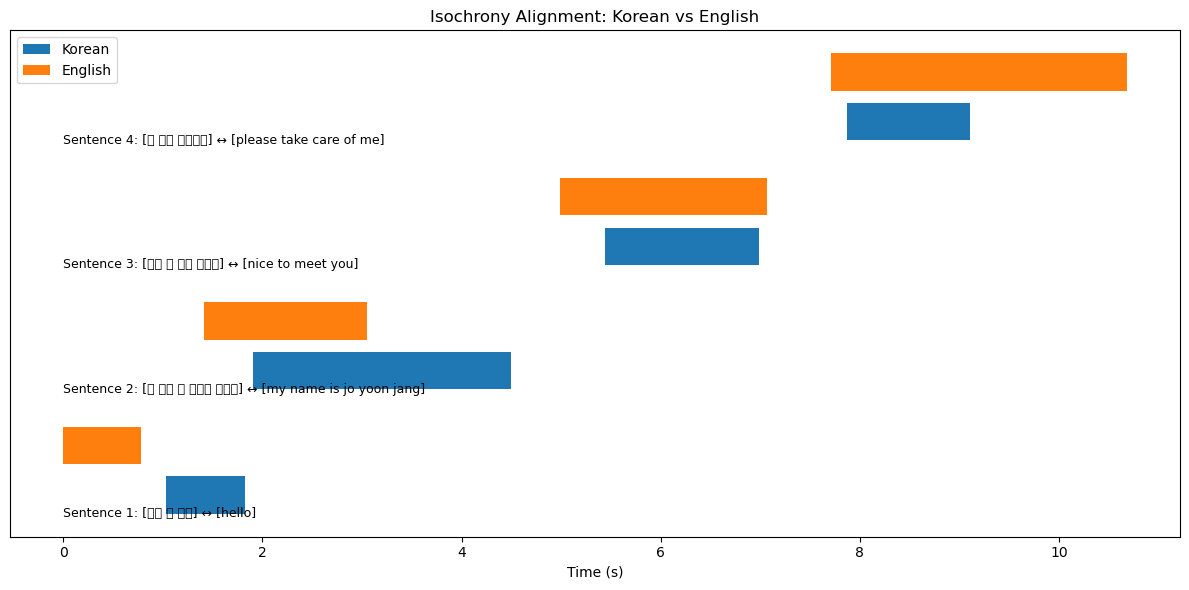


✅ Final Isochrony Score: 0.929
문장별 시간 차이: [0.02, 0.95, 0.53, 1.73]
평균 시간 차이: 0.81s
최대 시간 차이: 1.73s
최소 시간 차이: 0.02s

=== 시간 기반 자동 매핑 사용 ===
[하 + 세요 + 제] (1.69s ~ 1.97s, 0.28s)  ↔  [my + name + is + jo + yoon + jang] (1.41s ~ 3.05s, 1.64s)  → Δ = 1.36s
[이름 + 은 + 조윤장 + 입니다] (2.65s ~ 4.50s, 1.85s)  ↔  [my + name + is + jo + yoon + jang] (1.41s ~ 3.05s, 1.64s)  → Δ = 0.21s
[만나 + 서 + 반갑 + 습니다] (5.44s ~ 6.99s, 1.55s)  ↔  [to + meet + you] (6.10s ~ 7.07s, 0.97s)  → Δ = 0.58s
[잘 + 부탁 + 드립니다] (7.87s ~ 9.11s, 1.24s)  ↔  [please] (7.71s ~ 8.40s, 0.69s)  → Δ = 0.55s


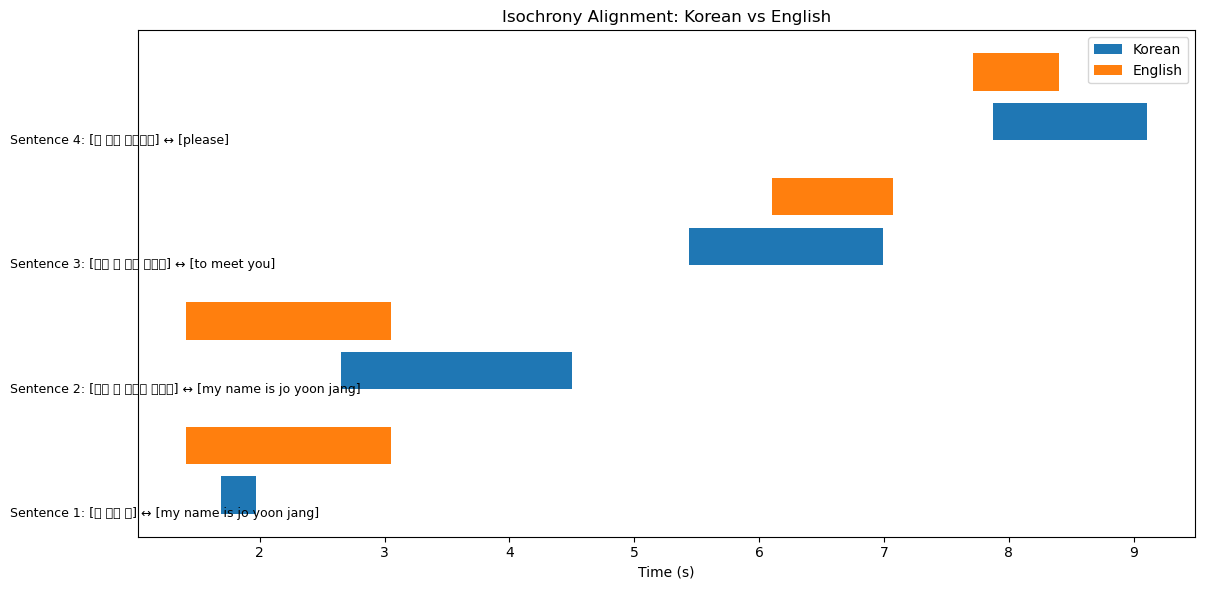


✅ Final Isochrony Score: 0.941
문장별 시간 차이: [1.36, 0.21, 0.58, 0.55]
평균 시간 차이: 0.67s
최대 시간 차이: 1.36s
최소 시간 차이: 0.21s


In [3]:
import matplotlib.pyplot as plt
from textgrid import TextGrid
import numpy as np
from collections import defaultdict

def normalize(text):
    return text.replace(" ", "").replace(".", "").replace(",", "").lower()

def find_combined_interval_multiple(tier, word_list):
    """
    tier 내에서 word_list에 해당하는 단어들의 시작 및 종료 시간 찾기
    """
    if not word_list:
        return None
        
    normalized_words = [normalize(w) for w in word_list if w.strip()]
    if not normalized_words:
        return None
        
    # 완전 일치 검색
    for i in range(len(tier)):
        mark = normalize(tier[i].mark)
        if not mark:
            continue

        matched = True
        j, k = 0, i
        start_time = None

        while j < len(normalized_words) and k < len(tier):
            mark_k = normalize(tier[k].mark)
            if not mark_k:
                k += 1
                continue
            if normalized_words[j] != mark_k:
                matched = False
                break
            if start_time is None:
                start_time = tier[k].minTime
            j += 1
            k += 1

        if matched and j == len(normalized_words):
            return (start_time, tier[k - 1].maxTime)
    
    # 완전 일치하지 않을 경우, 시작과 끝 단어만 찾아서 범위 설정
    if len(normalized_words) >= 2:
        first_word = normalized_words[0]
        last_word = normalized_words[-1]
        
        first_index = None
        last_index = None
        
        for i in range(len(tier)):
            mark = normalize(tier[i].mark)
            if not mark:
                continue
                
            if first_index is None and mark == first_word:
                first_index = i
            
            if mark == last_word:
                last_index = i
                
        if first_index is not None and last_index is not None and first_index <= last_index:
            return (tier[first_index].minTime, tier[last_index].maxTime)
    
    return None

# 수동 매핑 정의
def define_manual_mapping():
    """
    원본 한국어와 영어 문장의 매핑을 수동으로 정의
    """
    return [
        (["안녕", "하", "세요"], ["hello"]),
        (["제", "이름", "은", "조윤장", "입니다"], ["my", "name", "is", "jo", "yoon", "jang"]),
        (["만나", "서", "반갑", "습니다"], ["nice", "to", "meet", "you"]),
        (["잘", "부탁", "드립니다"], ["please", "take", "care", "of", "me"])
    ]

# ✅ 시간 경계선 기반 문장 자동 매핑
def auto_sentence_mapping_by_timing(tier_ko, tier_en, min_pause=0.5):
    """
    시간 경계선과 긴 휴지(pause)를 기준으로 문장 구분
    min_pause: 문장 구분을 위한 최소 휴지 시간(초)
    """
    def extract_sentences_by_pause(tier):
        sentences = []
        sentence = []
        last_end_time = 0
        
        for interval in tier:
            # 긴 휴지(pause) 감지
            if interval.minTime - last_end_time > min_pause:
                if sentence:
                    sentences.append((sentence, (sentence[0][1], sentence[-1][2])))
                    sentence = []
            
            # 빈 mark가 아닌 경우에만 추가
            if normalize(interval.mark):
                sentence.append((interval.mark, interval.minTime, interval.maxTime))
                last_end_time = interval.maxTime
        
        # 마지막 문장 추가
        if sentence:
            sentences.append((sentence, (sentence[0][1], sentence[-1][2])))
        
        return sentences

    # 한국어와 영어 문장 추출
    ko_sentences = extract_sentences_by_pause(tier_ko)
    en_sentences = extract_sentences_by_pause(tier_en)
    
    # 시간 겹침 기준으로 매핑
    mappings = []
    
    if len(ko_sentences) == len(en_sentences):
        # 문장 수가 같으면 순서대로 매핑
        for (ko_sent, ko_range), (en_sent, en_range) in zip(ko_sentences, en_sentences):
            ko_words = [word for word, _, _ in ko_sent]
            en_words = [word for word, _, _ in en_sent]
            mappings.append((ko_words, en_words))
    else:
        # 시간 중첩 기준으로 매핑
        for ko_idx, (ko_sent, ko_range) in enumerate(ko_sentences):
            ko_start, ko_end = ko_range
            best_match = None
            best_overlap = 0
            
            for en_idx, (en_sent, en_range) in enumerate(en_sentences):
                en_start, en_end = en_range
                
                # 시간 중첩 계산
                overlap_start = max(ko_start, en_start)
                overlap_end = min(ko_end, en_end)
                
                if overlap_end > overlap_start:
                    overlap = overlap_end - overlap_start
                    if overlap > best_overlap:
                        best_overlap = overlap
                        best_match = (en_sent, en_range)
            
            if best_match:
                ko_words = [word for word, _, _ in ko_sent]
                en_words = [word for word, _, _ in best_match[0]]
                mappings.append((ko_words, en_words))
    
    return mappings

# 메인 코드
def calculate_isochrony_score(ko_tg_path, en_tg_path, mapping_method="manual", min_pause=0.5):
    """
    Isochrony Score 계산 메인 함수
    
    mapping_method: 'manual' 또는 'auto_timing'
    min_pause: 자동 매핑 시 사용될 최소 휴지 시간
    """
    ko_tg = TextGrid.fromFile(ko_tg_path)
    en_tg = TextGrid.fromFile(en_tg_path)
    tier_ko = ko_tg.getFirst("words")
    tier_en = en_tg.getFirst("words")
    
    # 매핑 방법 선택
    if mapping_method == "manual":
        sentence_mapping = define_manual_mapping()
    elif mapping_method == "auto_timing":
        sentence_mapping = auto_sentence_mapping_by_timing(tier_ko, tier_en, min_pause)
    else:
        raise ValueError(f"Unknown mapping method: {mapping_method}")
    
    # 🔁 비교 및 시각화
    duration_diffs = []
    fig, ax = plt.subplots(figsize=(12, len(sentence_mapping)*1.5))
    
    for i, (ko_words, en_words) in enumerate(sentence_mapping):
        ko_range = find_combined_interval_multiple(tier_ko, ko_words)
        en_range = find_combined_interval_multiple(tier_en, en_words)
        
        if ko_range is None or en_range is None:
            print(f"⚠️ 누락된 매핑: {' + '.join(ko_words)} ↔ {' + '.join(en_words)}")
            continue
        
        ko_dur = ko_range[1] - ko_range[0]
        en_dur = en_range[1] - en_range[0]
        diff = abs(ko_dur - en_dur)
        duration_diffs.append(diff)
        
        # ⏱ word별 상세 출력
        print(f"[{' + '.join(ko_words)}] ({ko_range[0]:.2f}s ~ {ko_range[1]:.2f}s, {ko_dur:.2f}s)  ↔  "
              f"[{' + '.join(en_words)}] ({en_range[0]:.2f}s ~ {en_range[1]:.2f}s, {en_dur:.2f}s)  → Δ = {diff:.2f}s")
        
        # 📊 시각화
        ax.broken_barh([(ko_range[0], ko_dur)], (i*2.0 + 0.2, 0.6), facecolors='tab:blue', label='Korean' if i == 0 else "")
        ax.broken_barh([(en_range[0], en_dur)], (i*2.0 + 1.0, 0.6), facecolors='tab:orange', label='English' if i == 0 else "")
        ax.text(0, i*2.0 + 0.1, f"Sentence {i+1}: [{' '.join(ko_words)}] ↔ [{' '.join(en_words)}]", 
                fontsize=9, verticalalignment='bottom')
    
    # 스타일
    ax.set_yticks([])
    ax.set_xlabel("Time (s)")
    ax.set_title("Isochrony Alignment: Korean vs English")
    ax.legend()
    plt.tight_layout()
    plt.savefig('isochrony_alignment.png')
    plt.show()
    
    # 📏 최종 점수 출력
    if duration_diffs:
        total_duration = max(tier_ko.maxTime, tier_en.maxTime)
        ichron_score = 1 - (np.mean(duration_diffs) / total_duration)
        print(f"\n✅ Final Isochrony Score: {ichron_score:.3f}")
        
        # 자세한 점수 분석
        print(f"문장별 시간 차이: {[round(d, 2) for d in duration_diffs]}")
        print(f"평균 시간 차이: {np.mean(duration_diffs):.2f}s")
        print(f"최대 시간 차이: {max(duration_diffs):.2f}s")
        print(f"최소 시간 차이: {min(duration_diffs):.2f}s")
        
        return ichron_score
    else:
        print("❌ 유효한 매핑이 없어 점수를 계산할 수 없습니다.")
        return None

# 사용 예시
if __name__ == "__main__":
    # 수동 매핑 사용
    print("=== 수동 매핑 사용 ===")
    score1 = calculate_isochrony_score(
        "./sound_sample/korean_yunjang/윤장목소리1.TextGrid",
        "./sound_sample/AI_eng_yunjang/mine_en.TextGrid",
        mapping_method="manual"
    )
    
    # 시간 기반 자동 매핑 사용
    print("\n=== 시간 기반 자동 매핑 사용 ===")
    score2 = calculate_isochrony_score(
        "./sound_sample/korean_yunjang/윤장목소리1.TextGrid",
        "./sound_sample/AI_eng_yunjang/mine_en.TextGrid",
        mapping_method="auto_timing",
        min_pause=0.4  # 휴지 시간 임계값 조정
    )